# Imports

In [1]:
# HIDE 
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as t_optim
import pickle
from IPython import display
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import aif360 as aif

from fairness.helpers import load_ICU_data
from fairness.helpers import plot_distributions
from fairness.helpers import *

from fairness.avd_helpers import *
import aif360
from aif360.datasets import CompasDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
import tensorflow.compat.v1 as tf
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import LFR

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="colorblind", color_codes=True, context="talk")
sns.set_theme()

tf.disable_eager_execution()

%matplotlib inline

pip install 'aif360[LawSchoolGPA]'
2023-02-09 12:29:49.004648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


# Load Data

In [5]:
df = pd.read_csv('../../data/credit/default of credit card clients.csv', sep=';', header=1)

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [10]:
X = pd.get_dummies(df.drop(columns=['SEX', 'default payment next month', 'ID']))
y = df.rename({'default payment next month': 'default'}, axis=1).default
Z = (df.SEX==1).astype(int)

In [11]:
(X_train, X_test, y_train, y_test, Z_train, Z_test) = split_scale_pipe(X, y, Z, stratify=y)

### Train Biased Classifier

In [17]:
train_data = TensorDataset(
    torch.Tensor(X_train.to_numpy()), torch.Tensor(y_train.to_numpy()).reshape(-1,1), torch.Tensor(Z_train.to_numpy())
)
test_data = TensorDataset(
    torch.Tensor(X_test.to_numpy()), torch.Tensor(y_test.to_numpy()), torch.Tensor(Z_test.to_numpy())
)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)


clf = Classifier_old(n_features=X_train.shape[1])
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

N_CLF_EPOCHS = 30

# pretrain classifier

biased_model, losses = fit_clf(clf, clf_optimizer, clf_criterion, train_loader, num_epochs=N_CLF_EPOCHS)

preds = biased_model(test_data.tensors[0]).detach()

y_pred = pd.Series(preds.data.numpy().ravel(),
                     index=y_test.index)

acc = metrics.accuracy_score(y_test, y_pred > 0.5) * 100
b_acc = metrics.balanced_accuracy_score(y_test, y_pred > 0.5) * 100
prule = p_rule(y_pred, Z_test.values)

print(f'accuracy = {acc:.2f}%')
print(f'balanced accuracy = {b_acc:.2f}%')
print(f'p-rule = {prule:2f}%')

accuracy = 81.23%
balanced accuracy = 66.66%
p-rule = 85.543194%


In [19]:
test_results = pd.DataFrame(Z_test).assign(biased_pred = (y_pred>0.5)*1,
                                          target = y_test).rename({'SEX':'sex'}, axis=1)
test_results.head()

,sex,biased_pred,target
9112,0,0,0
5514,0,0,0
10884,1,0,0
14055,0,0,0
4164,1,0,0


### LFR

In [20]:
from aif360.sklearn.preprocessing import LearnedFairRepresentations as LFRsk

pip install 'aif360[FairAdapt]'


In [22]:
lfrsk = LFRsk(prot_attr='sex', reconstruct_weight=0.01,
                 target_weight=1., fairness_weight=14, random_state=11).fit(X_train.assign(sex=Z_train).set_index('sex'), y_train)

X_train_transf = lfrsk.transform(X_train.assign(sex=Z_train).set_index('sex')).set_index(X_train.index)
X_test_transf = lfrsk.transform(X_test.assign(sex=Z_test).set_index('sex')).set_index(X_test.index)

train_data = TensorDataset(torch.Tensor(X_train_transf.to_numpy()), 
                           torch.Tensor(y_train.to_numpy().reshape(-1,1)),
                           torch.Tensor(Z_train.to_numpy()))

test_data = TensorDataset(torch.Tensor(X_test_transf.to_numpy()), 
                          torch.Tensor(y_test.to_numpy()), 
                          torch.Tensor(Z_test.to_numpy()))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)

start = time.time()

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)

clf = Classifier_old(n_features=X_train.shape[1])
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

n_epochs = 30

# pretrain classifier

clf, losses = fit_clf(clf, clf_optimizer, clf_criterion, train_loader, num_epochs=n_epochs)

with torch.no_grad():
    preds = clf(test_data.tensors[0])

y_pred = pd.Series(preds.data.numpy().ravel(),
                     index=y_test.index)

acc = metrics.accuracy_score(y_test, y_pred > 0.5) * 100
b_acc = metrics.balanced_accuracy_score(y_test, y_pred > 0.5) * 100
prule = p_rule(y_pred, Z_test.values)

print(f'accuracy = {acc:.2f}%')
print(f'balanced accuracy = {b_acc:.2f}%')
print(f'p-rule = {prule:2f}%')

accuracy = 80.26%
balanced accuracy = 62.91%
p-rule = 95.229737%


In [24]:
test_results = test_results.assign(
    lfr_pred = (y_pred>0.5).astype(int)
)

In [25]:
test_results = test_results.assign(lfr_change = test_results.lfr_pred - test_results.biased_pred)

### Adversarial Debiasing

In [26]:
from fairlearn_int.adversarial import AdversarialFairnessClassifier as AFC
from fairlearn_int.metrics import equalized_odds_difference, equalized_odds_ratio

In [27]:
afc = AFC(backend='torch',
   predictor_model=[32, nn.ReLU(), 32, nn.ReLU(), 32, nn.ReLU()],
   adversary_model=[200, nn.ReLU()],
   epochs=30,
   alpha=14).fit(X_train, y_train, sensitive_features=Z_train)

preds = afc.predict(X_test)

In [28]:
print(f'accuracy = {metrics.accuracy_score(y_test, (preds>0.5) * 1) * 100:.2f}%')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, (preds>0.5) * 1) * 100:.2f}%')
print(f'p-rule = {p_rule((preds>0.5) * 1, Z_test.values):.2f}%')

accuracy = 80.79%
balanced accuracy = 64.55%
p-rule = 90.41%


In [29]:
preds.index=test_results.index

In [30]:
test_results = test_results.assign(adv_pred = (preds>0.5)*1, adv_change = (preds>0.5)*1 - test_results.biased_pred)
test_results.head()

,sex,biased_pred,target,lfr_pred,lfr_change,adv_pred,adv_change
9112,0,0,0,0,0,0,0
5514,0,0,0,0,0,0,0
10884,1,0,0,0,0,0,0
14055,0,0,0,0,0,0,0
4164,1,0,0,0,0,0,0


### Adversarial Learning (Equalized Odds)

In [31]:
from fairlearn_int.adversarial import AdversarialFairnessClassifier as AFC
from fairlearn_int.metrics import equalized_odds_difference, equalized_odds_ratio

In [55]:
afc = AFC(backend='torch',
   predictor_model=[32, nn.ReLU(), 32, nn.ReLU(), 32, nn.ReLU()],
   adversary_model=[200, nn.ReLU()],
   constraints='equalized_odds',
   epochs=30,
   alpha=25).fit(X_train, y_train, sensitive_features=Z_train)

preds = afc.predict(X_test)

In [56]:
preds.index = X_test.index
test_results = test_results.assign(adveq_pred = preds, adveq_change = preds - test_results.biased_pred)

In [59]:
print('Adversarial (optimizing equalized odds):')
print(f'accuracy = {metrics.accuracy_score(y_test, preds) * 100:.2f}%')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, preds) * 100:.2f}%')
dm = disparate_mistreatment(test_results[['sex', 'target', 'adveq_pred']].rename({'adveq_pred':'fair_label'}, axis=1), 'sex')
print(f'disparate mistreatement: D(FPR) = {dm[0]:.2f}, D(TPR) = {dm[1]:.2f}')

print()
print('Biased:')
print(f'accuracy = {metrics.accuracy_score(y_test, biased_preds) * 100:.2f}%')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, biased_preds) * 100:.2f}%')
dm = disparate_mistreatment(test_results[['sex', 'target', 'biased_pred']].rename({'biased_pred':'fair_label'}, axis=1), 'sex')
print(f'disparate mistreatement: D(FPR) = {dm[0]:.2f}, D(TPR) = {dm[1]:.2f}')

Adversarial (optimizing equalized odds):
accuracy = 81.57%
balanced accuracy = 64.44%
disparate mistreatement: D(FPR) = 0.79, D(TPR) = 0.87

Biased:
accuracy = 81.23%
balanced accuracy = 66.66%
disparate mistreatement: D(FPR) = 1.25, D(TPR) = 1.16


### Equal Odds

In [60]:
from fairlearn_int.postprocessing import ThresholdOptimizer as TO

In [61]:
bld_train = BinaryLabelDataset(df=X_train.assign(y = y_train, sex = Z_train), label_names=['y'], protected_attribute_names=['sex'])

In [62]:
m = TO(estimator=biased_model, predict_method='predict',
       prefit=True, constraints='equalized_odds',
      objective='accuracy_score').fit(X=X_train.assign(sex=Z_train).set_index('sex'), 
                                                             y=y_train,
                                                             Z=Z_train, 
                                                             sensitive_features=Z_train,
                                                                         bld=None)

In [63]:
preds = m.predict(X=X_test, y=y_test, Z=Z_test, sensitive_features=Z_test,
                  bld=None)
                 

In [66]:
test_results = test_results.assign(
    eq_pred = preds,
    eq_change = preds - test_results.biased_pred
)

In [68]:
acc = metrics.accuracy_score(y_test, preds)
b_acc = metrics.balanced_accuracy_score(y_test, preds)
dm = disparate_mistreatment(test_results[['sex', 'target', 'eq_pred']].rename({'eq_pred':'fair_label'}, axis=1), 'sex')

print(f'accuracy = {acc:.2f}')
print(f'balanced accuracy = {b_acc:.2f}')
print(f'disparate mistreatement: D(FPR) = {dm[0]:.2f}, D(TPR) = {dm[1]:.2f}')

accuracy = 0.81
balanced accuracy = 0.66
disparate mistreatement: D(FPR) = 0.41, D(TPR) = 1.22


### Reject Option Classification

In [69]:
from fairness.avd_helpers import RejectOptionClassifier

In [70]:
scores = biased_model(test_data.tensors[0]).detach().numpy().flatten()
labels = (scores>0.5)*1

preds = RejectOptionClassifier(0.545).predict(scores, Z_test.values)

In [72]:
print(f'accurcy = {metrics.accuracy_score(y_test, labels)*100:.2f}')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, labels)*100:.2f}')
print(f'p-rule = {p_rule(scores, Z_test.values):.2f}')

print('-------------')
print('debiased:')

print(f'accuracy = {metrics.accuracy_score(y_test, preds)*100:.2f}')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, preds)*100:.2f}')
print(f'p-rule = {p_rule(preds, Z_test.values):.2f}')

accurcy = 81.23
balanced accuracy = 66.66
p-rule = 85.54
-------------
debiased:
accuracy = 81.19
balanced accuracy = 66.01
p-rule = 96.97


In [76]:
test_results = test_results.assign(
    roc_pred=preds,
    roc_change = preds - test_results.biased_pred
)

# Comparisons

In [78]:
test_results.head()
t = test_results

In [81]:
metrics_ = get_metrics([t[['sex', 'target', 'adv_pred', 'biased_pred']].rename({'biased_pred':'biased_label', 'adv_pred':'fair_label'}, axis=1),
                        t[['sex', 'target', 'roc_pred']].rename({'biased_pred':'biased_label', 'roc_pred':'fair_label'}, axis=1),
                        t[['sex', 'target', 'lfr_pred']].rename({'biased_pred':'biased_label', 'lfr_pred':'fair_label'}, axis=1),
                        t[['sex', 'target', 'adveq_pred']].rename({'biased_pred':'biased_label', 'adveq_pred':'fair_label'}, axis=1),
                        t[['sex', 'target', 'eq_pred']].rename({'biased_pred':'biased_label', 'eq_pred':'fair_label'}, axis=1),
                       ],
                       ['adversarial (dem parity)', 'ROC', 'LFR', 'adversarial (eq odds)', 'eq odds'],
                       sensitive_feature='sex'
                      )
metrics_.drop(columns=['class 0 accuracy', 'class 1 accuracy'])


,approach,accuracy,balanced accuracy,p% rules,fpr_diffs,tpr_diffs
0,adversarial (dem parity),0.807867,0.645543,90.411716,0.499417,0.158952
1,ROC,0.811933,0.660129,96.969541,0.059671,2.929474
2,LFR,0.802600,0.629106,95.229737,0.212243,1.909052
3,adversarial (eq odds),0.815733,0.644443,85.753329,0.788455,0.874456
4,eq odds,0.811867,0.658360,92.476784,0.412622,1.224714
5,biased,0.812267,0.666601,85.543194,0.499417,0.158952


Text(0.5, 1.0, 'Methods Optimizing Equalized Odds')

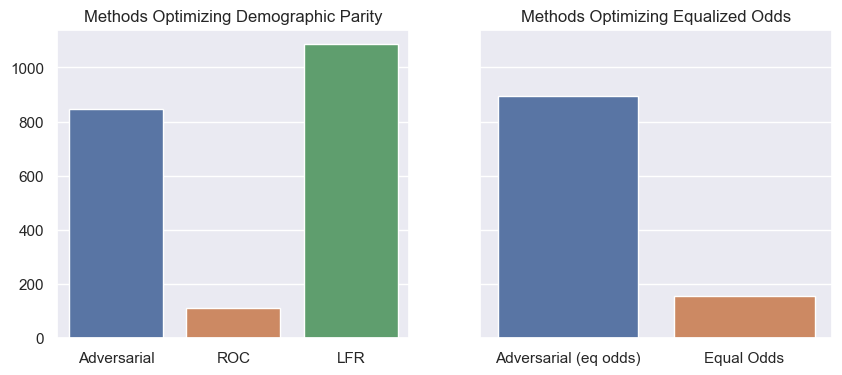

In [83]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)

sns.barplot(
    x=['Adversarial', 'ROC', 'LFR'],
    y=[len(t[t.adv_change!=0]), len(t[t.roc_change!=0]),
      len(t[t.lfr_change!=0])],
    ax=axs[0]
           )
axs[0].set_title('Methods Optimizing Demographic Parity')

sns.barplot(
    x = ['Adversarial (eq odds)', 'Equal Odds'],
    y = [len(t[t.adveq_change!=0]), len(t[t.eq_change!=0])],
    ax=axs[1]
)
axs[1].set_title('Methods Optimizing Equalized Odds')

In [89]:
tt = t[(t.adv_change!=0) | (t.roc_change!=0) | (t.lfr_change!=0)]
inters_dp = len(tt[(tt.adv_change==tt.roc_change) & (tt.lfr_change==tt.roc_change) & (tt.lfr_change==tt.adv_change)])
union_dp = len(tt)
iou_dp = inters_dp/union_dp * 100

print('Demographic parity methods:')
print(f'IOU(changed instances) = {iou_dp:.2f}%')

tt = t[(t.adveq_change!=0) | (t.eq_change!=0)]
inters_eo = len(tt[(tt.adveq_change==tt.eq_change)])
union_eo = len(tt)
iou_eo = inters_eo/union_eo * 100

print('Equalized Odds methods:')
print(f'IOU(changed instances) = {iou_eo:.2f}%')

tt = t[(t.adv_change!=0) | (t.roc_change!=0) | (t.lfr_change!=0) | (t.adveq_change!=0) | (t.eq_change!=0)]
inters = len(tt[
    (tt.adv_change==tt.roc_change) & (tt.lfr_change==tt.roc_change) & (tt.lfr_change==tt.adv_change) &
    (tt.adveq_change==tt.eq_change) &
    (tt.adv_change==tt.adveq_change) & (tt.lfr_change==tt.adveq_change) & (tt.roc_change==tt.adveq_change) &
    (tt.adv_change==tt.eq_change) & (tt.lfr_change==tt.eq_change) & (tt.roc_change==tt.eq_change) 
])
union = len(tt)
iou = inters/union

print('All methods:')
print(f'IOU(changed instances) = {iou:.2f}%')

Demographic parity methods:
IOU(changed instances) = 2.75%
Equalized Odds methods:
IOU(changed instances) = 9.02%
All methods:
IOU(changed instances) = 0.02%


In [90]:
print('LFR:')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.lfr_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.lfr_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()

print('Adversarial (DP):')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.adv_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.adv_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()

print('ROC:')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.roc_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.roc_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()

print('Biased:')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.biased_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.biased_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()


LFR:
disadv group in positive class: 11.46%
priv group in positive class: 12.04%

Adversarial (DP):
disadv group in positive class: 12.26%
priv group in positive class: 13.56%

ROC:
disadv group in positive class: 13.68%
priv group in positive class: 14.11%

Biased:
disadv group in positive class: 13.68%
priv group in positive class: 15.99%



In [92]:
t_fts = df.loc[t.index].join(t)

adv_changed = t_fts[t_fts.adv_change!=0]
eq_changed = t_fts[t_fts.eq_change!=0]
roc_changed = t_fts[t_fts.roc_change!=0]

adv_changed.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,lfr_pred,lfr_change,adv_pred,adv_change,adveq_pred,adveq_change,eq_pred,eq_change,roc_pred,roc_change
24674,24675,30000,1,2,2,35,2,2,-2,-2,...,0,-1,0,-1,1,0,1,0,1.0,0.0
7776,7777,360000,2,2,1,46,1,-2,-2,-2,...,0,0,1,1,0,0,0,0,0.0,0.0
13261,13262,60000,2,2,1,60,8,7,6,5,...,1,0,0,-1,1,0,1,0,1.0,0.0
28761,28762,20000,2,3,2,34,1,-2,-2,-2,...,0,-1,0,-1,0,-1,1,0,1.0,0.0
28791,28792,180000,2,3,1,44,1,-2,-2,-2,...,0,-1,0,-1,0,-1,1,0,1.0,0.0


# T-sne and PCA

In [98]:
a_df = t[t.adv_change!=0]
l_df = t[t.lfr_change!=0]
e_df = t[t.eq_change!=0]
r_df = t[t.roc_change!=0]
ae_df = t[t.adv_change!=0]

In [94]:
from sklearn.manifold import TSNE

tsne_df = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=25).fit_transform(X_test)#.assign(z = Z_test))

In [96]:
import matplotlib.patches as mpatches
from fairness.helpers import *

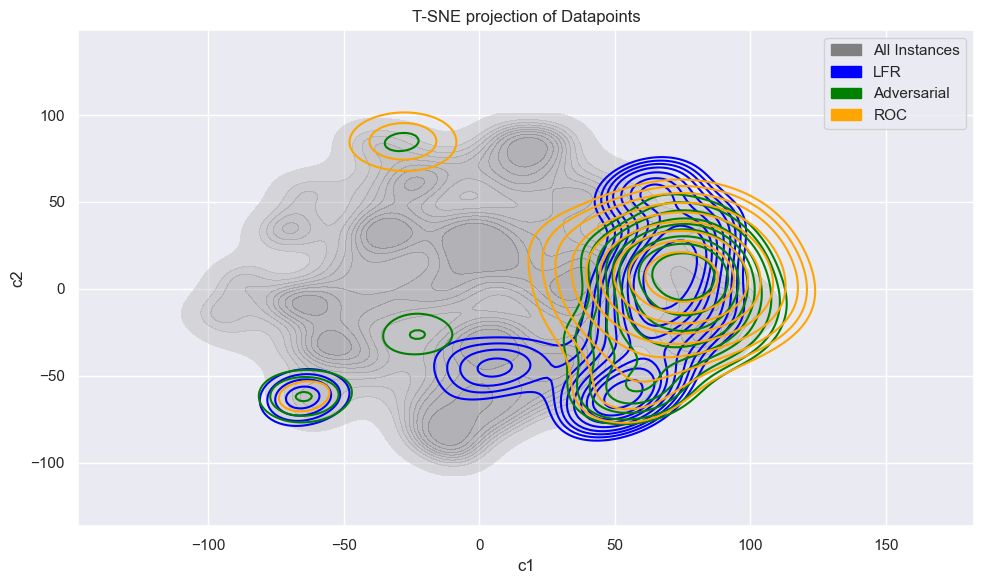

In [99]:
tsne_plot(
    pd.DataFrame(tsne_df, index=X_test.index, columns=['c1', 'c2']),
    {'LFR': l_df, 'Adversarial':a_df, 'ROC':r_df},
    {'LFR': 'Blue', 'Adversarial':'Green', 'ROC':'Orange'}
)

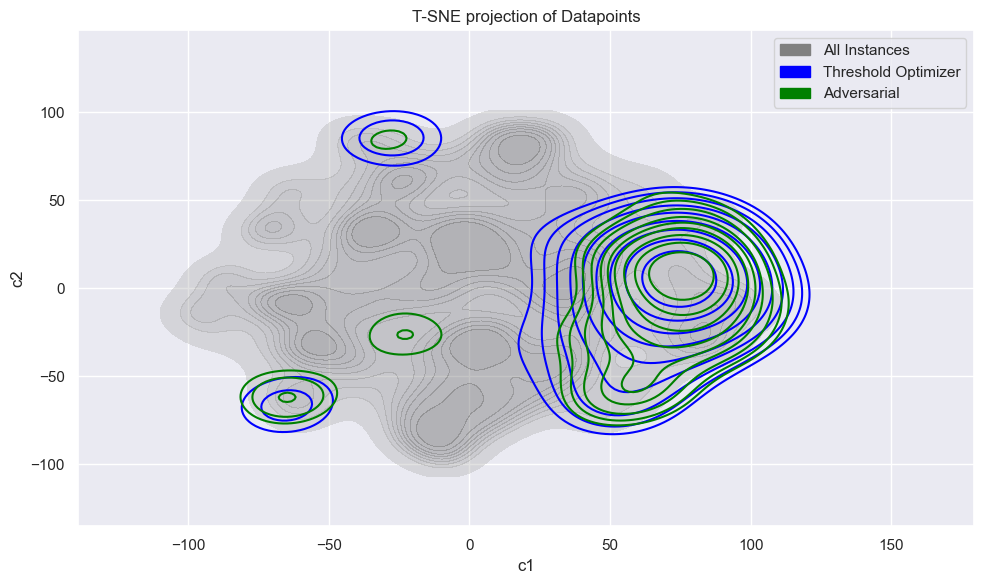

In [100]:
tsne_plot(
    pd.DataFrame(tsne_df, index=X_test.index, columns=['c1', 'c2']),
    {'Threshold Optimizer': e_df, 'Adversarial':ae_df},
    {'Threshold Optimizer': 'Blue', 'Adversarial':'Green'}
)

In [ ]:
import umap
from umap import UMAP

In [ ]:
reducer = umap.UMAP()

In [ ]:
embedding = reducer.fit_transform(X_test)

In [ ]:
umap_df = pd.DataFrame(embedding, columns=['c1', 'c2'], index=X_test.index)
umap_df.head()

In [ ]:
sns.kdeplot(data=umap_df, x='c1', y='c2')#, kind='hex')

In [ ]:
all_df = umap_df#X_test.assign(c1 = umap_df[:,0],
             #c2 = umap_df[:,1])

plot_a = all_df.loc[a_df.index]
plot_l = all_df.loc[l_df.index]
plot_e = all_df.loc[e_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.1, alpha=0.4, legend=True, color='Grey', cut=0.5)

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.6, color='Blue')#, cut=0.3)
patch_eq = mpatches.Patch(
    color='Blue', label='Equal Odds'
)

sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.6, color='Green')#, cut=0.3)
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs, label='LFR', fill=False, thresh=0.6, color='Orange')#, cut=0.3)
patch_lfr = mpatches.Patch(
    color='Orange', label='LFR'
)

label_patches = [patch_all, patch_eq, patch_adv, patch_lfr]


axs.legend(handles=label_patches)

axs.set_title('Umap projection of Datapoints')

plt.xlim((-30,40))
plt.ylim((-30,40))

plt.tight_layout()

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()

In [ ]:
embedding = reducer.fit_transform(changed)

In [ ]:
umap_df = pd.DataFrame(embedding, columns=['c1', 'c2'], index=changed.index)
umap_df.head()

In [ ]:
sns.kdeplot(data=umap_df, x='c1', y='c2')#, kind='hex')

In [ ]:
all_df = umap_df#X_test.assign(c1 = umap_df[:,0],
             #c2 = umap_df[:,1])

plot_a = all_df.loc[a_df.index]
plot_l = all_df.loc[l_df.index]
plot_e = all_df.loc[e_df.index]
plot_x = all_df#.loc[same_df.index]

fig, axs = plt.subplots(1,1, figsize=(10,6))#, sharex=True, sharey=True)

sns.kdeplot(data=plot_x, x='c1', y='c2', ax=axs, label='All Instances', fill=True, 
            thresh=0.1, alpha=0.4, legend=True, color='Grey', cut=0.5)

patch_all = mpatches.Patch(
    color='Grey', label='All Instances'
)

sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs, label='LFR', fill=False, thresh=0.6, color='Orange')#, cut=0.3)
patch_lfr = mpatches.Patch(
    color='Orange', label='LFR'
)

sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs, label='Equal Odds', fill=False, thresh=0.6, color='Blue')#, cut=0.3)
patch_eq = mpatches.Patch(
    color='Blue', label='Equal Odds'
)

sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs, label='Adversarial', fill=False, thresh=0.6, color='Green')#, cut=0.3)
patch_adv = mpatches.Patch(
    color='Green', label='Adversarial'
)

label_patches = [patch_all, patch_eq, patch_adv, patch_lfr]


axs.legend(handles=label_patches)

axs.set_title('Umap projection of Datapoints')

plt.xlim((-30,40))
plt.ylim((-20,35))

plt.tight_layout()

In [ ]:
import discrepancies as disc
from discrepancies import pool
from discrepancies import DIG

In [ ]:
class LFR_model:
    
    def __init__(self, lfr, model):
        self.lfr = lfr
        self.model = model
    
    def fit(self):
        pass
    
    def predict(self, XZ):
        bld = BinaryLabelDataset(df=XZ.assign(score_factor=0),
                                label_names=['score_factor'],
                                protected_attribute_names=['race'])
        return self.model.predict(self.lfr.transform(bld)).labels
    
class EQ_model:
    
    def __init__(self, model):
        self.model = model
    
    def fit(self):
        pass
    
    def predict(self, XZ):
        
        bld = BinaryLabelDataset(df=XZ.assign(score_factor=0),
                                label_names=['score_factor'],
                                protected_attribute_names=['race'])
        
        X = XZ.drop(columns = ['race'])
        y = pd.Series(np.zeros(len(X)), name='score_factor')
        Z = XZ['race']
        
        return self.model.predict(
            X=X, y=y, Z=Z, sensitive_features=Z,
            bld=bld
        )
    
class Adversarial_model:
    
    def __init__(self, model):
        self.model = model
        
    def fit(self):
        pass
    
    def predict(self, XZ):
        
        bld = BinaryLabelDataset(df=XZ.assign(score_factor=0),
                                label_names=['score_factor'],
                                protected_attribute_names=['race'])
        
        return self.model.predict(bld).labels

In [ ]:
lfr_wrap = LFR_model(lfr, model)
eq_wrap = EQ_model(m)
adv_wrap = Adversarial_model(debiased_model)
biased_wrap = Adversarial_model(biased_model)

#fpool = pool.FairnessPool([lfr_wrap, eq_wrap, adv_wrap, biased_wrap], 
#                          ['LFR', 'Equal Odds', 'Adversarial', 'Biased'],
#                         'race')

eq_pool = pool.FairnessPool([eq_wrap, biased_wrap], ['Equal Odds', 'Biased'], 'race')
adv_pool = pool.FairnessPool([adv_wrap, biased_wrap], ['Adversarial', 'Biased'], 'race')
lfr_pool = pool.FairnessPool([lfr_wrap, biased_wrap], ['LFR', 'Biased'], 'race')

In [ ]:
adv_pool.predict(XZ=X_test.join(y_test).join(Z_test))

In [ ]:
sample = X_test.join(Z_test).join(y_test).sample(100).assign(score_factor=0)
bld_sample = BinaryLabelDataset(
    df=sample,
    label_names=['score_factor'],
    protected_attribute_names=['race']
)

In [ ]:
sample.head()

In [ ]:
adv_pool.predict_discrepancies(sample)

In [ ]:
eq_digger = DIG.Digger(
    sample.drop(columns=['score_factor']),
    sample.score_factor,
    eq_pool,
    categorical_names=['sex', 'felony']
).fit(max_epochs=7)

In [ ]:
adv_digger = DIG.Digger(
    sample.drop(columns=['score_factor']),
    sample.score_factor,
    adv_pool,
    categorical_names=['sex', 'felony']
).fit(max_epochs=7)

In [ ]:
nodes = pd.concat([adv_digger.get_nodes_attributes(adv_digger.get_nodes())[0],
           adv_digger.get_nodes_attributes(adv_digger.get_nodes())[1]],
         axis=1).assign(discrepancy = lambda x: (x['Adversarial']!=x['Biased']).astype(int))

nodes.head()#[nodes.isna().any(axis=1)]

In [ ]:
(trainx, testx, trainy, testy,
     trainz, testz) = train_test_split(X, y, Z, test_size=0.5,
                                         stratify=y, random_state=11)

scaler = StandardScaler().fit(trainx)

nodes_unscaled = pd.DataFrame(scaler.inverse_transform(nodes[X_test.columns]), columns=X_test.columns,
            index=nodes.index)
nodes_unscaled.head()

In [ ]:
dff = pd.concat([
    nodes_unscaled,
    nodes[['race', 'Adversarial', 'Biased']]
], axis=1).assign(discrepancy = lambda x: (x['Adversarial']!=x['Biased']).astype(int))\
  .drop(columns=['Adversarial', 'Biased'])\
  .assign(race = lambda x: (x.race>0.5).astype(int))
dff.head()

In [ ]:
testx.describe()

In [ ]:
dff.describe()

In [ ]:
sc_dfff = nodes.assign(discrepancy = lambda x: (x['Adversarial']!=x['Biased']).astype(int)).drop(columns=['Adversarial', 'Biased', 'race'])

In [ ]:
#x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(dff.drop(columns=['discrepancy']),
#                                                                       dff[['discrepancy']],
#                                                                       test_size=0.5, stratify=dff[['discrepancy']], random_state=11)

#x_tree_train, x_tree_test, y_tree_train, y_tree_test = train_test_split(sc_dfff.drop(columns=['discrepancy']),
#                                                                       sc_dfff[['discrepancy']],
#                                                                       test_size=0.5, stratify=sc_dfff[['discrepancy']], random_state=11)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=10)
clf = clf.fit(x_tree_train.to_numpy(), y_tree_train)

In [ ]:
preds = clf.predict(x_tree_test)

metrics.balanced_accuracy_score(y_tree_test, preds)

In [ ]:
from sklearn import tree

fig, axs = plt.subplots(1,1,figsize=(18,10))

tree.plot_tree(clf)

plt.show()

In [ ]:
list(X_test.columns)+['race']

In [ ]:
dff.race.unique()

In [ ]:
import graphviz

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=list(X_test.columns), class_names=['not changed', 'changed'])
graph = graphviz.Source(dot_data)
#graph.render('adult'),

In [ ]:
graph.render('compas_adv')

In [ ]:
leaves = clf.apply(x_tree_test)

In [ ]:
tree_df = pd.DataFrame(scaler.inverse_transform(x_tree_test), columns=x_tree_test.columns, index=x_tree_test.index)\
            .assign(leaf=leaves).assign(discrepancy=y_tree_test)
tree_df.head()

In [ ]:
tree_df.groupby(['leaf', 'discrepancy']).count().reset_index().sort_values(['discrepancy', 'sex'], ascending=False)[0:10] #.sort_values('sex')

In [ ]:
x_tree_test.shape

In [ ]:
tree_df[tree_df.leaf==315].describe().drop(columns=['leaf', 'discrepancy']).loc[['min', 'max']].rename({'sex':'Gender',
                                                                                                       'age':'Age',
                                                                                                       'priors_count':'Priors',
                                                                                                       'juv_fel_count':'Juvenial Felonies',
                                                                                                       'juv_misd_count':'Juvenial Misdemeanors',
                                                                                                       'felony':'Felony'}, axis=1)

In [ ]:
tree_df[tree_df.leaf==263].describe().drop(columns=['leaf', 'discrepancy']).loc[['min', 'max']].rename({'sex':'Gender',
                                                                                                       'age':'Age',
                                                                                                       'priors_count':'Priors',
                                                                                                       'juv_fel_count':'Juvenial Felonies',
                                                                                                       'juv_misd_count':'Juvenial Misdemeanors',
                                                                                                       'felony':'Felony'}, axis=1)

In [ ]:
tree_df.head()

In [ ]:
t.groupby(['race', 'eq_change']).count()

In [ ]:
x_tree_train.head()

In [ ]:
nodes.assign()

In [ ]:
t.head()

In [ ]:
t.head()

In [ ]:
plot_df = dd.loc[t.index].assign(
    eq_change = t.eq_change,
    adv_change = t.adv_change,
    lfr_change = t.lfr_change
)

In [ ]:
plot_df[plot_df.eq_change!=0].describe()[['age', 'priors_count', 'juv_fel_count', 'juv_misd_count']]

In [ ]:
plot_df[plot_df.eq_change!=0].groupby('race').count()[['sex']].rename({'sex':'count'}).assign(method='Equal Odds').reset_index()

In [ ]:
plot_df[plot_df.lfr_change!=0].groupby('race').count()[['sex']].rename({'sex':'count'})

In [ ]:
plot_df[plot_df.adv_change!=0].groupby('race').count()[['sex']].rename({'sex':'count'})

In [ ]:
plot_df[plot_df.lfr_change!=0].describe()[['age', 'priors_count', 'juv_fel_count', 'juv_misd_count']]

In [ ]:
testx.head()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
clusters = AgglomerativeClustering(n_clusters=10).fit_predict(nodes[nodes.discrepancy==1].drop(columns=['discrepancy', 'Adversarial', 'Biased']))

In [ ]:
agl_clusters = nodes[nodes.discrepancy==1].assign(cluster=clusters)
agl_clusters.head()

In [ ]:
from sklearn.cluster import AffinityPropagation

AffinityPropagation().fit_predict(trainx[trainx.discrepancy==1].drop(columns=['discrepancy', 'Adversarial', 'Biased']))

In [ ]:
from sklearn.manifold import TSNE

tsne_df = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=50).fit_transform(agl_clusters.drop(columns=['discrepancy', 'Adversarial', 'Biased', 'cluster']))


In [ ]:
all_df = agl_clusters.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

all_df.head()

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(14,7))

sns.scatterplot(data=all_df, x='c1', y='c2', hue='cluster', palette='colorblind')

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(14,7))

sns.scatterplot(data=all_df, x='c1', y='c2', palette='colorblind')

In [ ]:
all_df[all_df.cluster==1].describe()[['age', '']]

In [ ]:
len(all_df)

In [ ]:
sns.kdeplot(data=all_df, x='c1', y='c2', thresh = 0.6)

In [ ]:
all_df = changed.assign(c1 = tsne_df[:,0],
             c2 = tsne_df[:,1])

fig, axs = plt.subplots(1,1, figsize=(18,6))#, sharex=True, sharey=True)

sns.kdeplot(data=all_df, x='c1', y='c2', ax=axs, label='All Instances', fill=False, thresh=0.3)
sns.kdeplot(data=plot_e, x='c1', y='c2', ax=axs[1] , label='Equal Odds', fill=False, thresh=0.3)
sns.kdeplot(data=plot_a, x='c1', y='c2', ax=axs[1] , label='Adversarial', fill=False, alpha=0.6, thresh=0.3)
sns.kdeplot(data=plot_l, x='c1', y='c2', ax=axs[1] , label='LFR', fill=False, alpha=0.4, thresh=0.3)

plt.tight_layout()

In [ ]:
t.head()

In [ ]:
y_tree = (t.biased_pred!=t.adv_pred).astype(int)

In [ ]:
(X_train_og, X_test_og, _, _,
     _, _) = train_test_split(X, y, Z, test_size=0.5,
                                         stratify=y, random_state=11)

og_scaler = StandardScaler().fit(X_train_og)

In [ ]:
check = pd.concat([pd.DataFrame(og_scaler.inverse_transform(X_test), index=X_test.index, columns=X_test.columns), 
           X_test_og], axis=1)
check[check.sex!=check.sex_og]

In [ ]:
X_test_og.columns = X_test_og.columns.map(lambda x: x+'_og')

In [ ]:
tree_data = X_test.assign(race=Z_test)

scaler = StandardScaler().fit(tree_data)

scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), 
                                           columns=df.columns, index=df.index)
tree_data = tree_data.pipe(scale_df, scaler)

In [ ]:
tree_data.head()

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=6)
clf = clf.fit(tree_data.to_numpy(), y_tree)

In [ ]:
preds = clf.predict(tree_data)

metrics.balanced_accuracy_score(y_tree, preds)

In [ ]:
clusters = clf.apply(tree_data)

In [ ]:
cc = pd.DataFrame(og_scaler.inverse_transform(pd.DataFrame(scaler.inverse_transform(tree_data), 
                                         index=tree_data.index,
                                         columns=tree_data.columns).drop(columns=['race'])),
            index=tree_data.index,
            columns=X_test.columns)
cc = cc.assign(
    priors_count = round(cc.priors_count),
    juv_fel_count = round(cc.juv_fel_count)
)

In [ ]:
cc = cc.assign(segment=clusters, y=y_tree)
cc.head()

In [ ]:
cc.groupby('segment').count()[['age']].sort_values('age', ascending=False).head(5)

In [ ]:
cc[cc.y==1].groupby('segment').count()[['age']].sort_values('age', ascending=False).head(5)

In [ ]:
cc[cc.segment==51].describe()

In [ ]:
cc[cc.segment==22].describe()

In [ ]:
df = pd.read_csv('../../results/compas/test_results.csv').rename({'Unnamed: 0': 'index'}, axis=1).set_index('index')\
                [['race', 'biased_pred', 'lfr_pred', 'adv_pred', 'eq_pred', 'target']]
df.head()

In [ ]:
comp = dd.loc[df.index].assign(
    biased_pred=df.biased_pred,
    adv_pred = df.adv_pred,
    lfr_pred = df.lfr_pred
)
comp.head()

In [ ]:
data = comp[comp.biased_pred != comp.adv_pred]
data_lfr = comp[comp.biased_pred != comp.lfr_pred]

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line_color='blue',
        dimensions = list([
            dict(range = [data.age.min(), data.age.max()],
                 constraintrange = [1,2], # change this range by dragging the pink line
                 label = 'Age', values = data.age),
            
            dict(range = [0,1],
                 label = 'Race', values = data.race,
                 ticktext = ['Black', 'White']),
            
            dict(range = [0,1],
                 label = 'Sex', values = data.sex,
                 ticktext = ['Female', 'Male']),
            
            dict(range = [data.priors_count.min(), data.priors_count.max() ],
                 label = '# Priors', values = data.priors_count),
            
            dict(range = [data.juv_fel_count.min(), data.juv_fel_count.max()],
                 label='# juv. felonies', values = data.juv_fel_count
            ),
            dict(range = [data.biased_pred.min(), data.biased_pred.max()],
                 label='Biased Prediction', values = data.biased_pred
            )
        ])
    )
)
fig.show()

fig = go.Figure(data=
    go.Parcoords(
        line_color='blue',
        dimensions = list([
            dict(range = [data_lfr.age.min(), data_lfr.age.max()],
                 constraintrange = [1,2], # change this range by dragging the pink line
                 label = 'Age', values = data_lfr.age),
            
            dict(range = [0,1],
                 label = 'Race', values = data_lfr.race,
                 ticktext = ['Black', 'White']),
            
            dict(range = [0,1],
                 label = 'Sex', values = data_lfr.sex,
                 ticktext = ['Female', 'Male']),
            
            dict(range = [data_lfr.priors_count.min(), data_lfr.priors_count.max() ],
                 label = '# Priors', values = data_lfr.priors_count),
            
            dict(range = [0, 1],
                 label='# juv. felonies', values = data_lfr.juv_fel_count
            ),
            dict(range = [data_lfr.biased_pred.min(), data_lfr.biased_pred.max()],
                 label='Biased Prediction', values = data_lfr.biased_pred
            )
        ])
    )
)
fig.show()

In [ ]:
data_lfr.juv_fel_count.max()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line_color='blue',
        dimensions = list([
            dict(range = [data_lfr.age.min(), data_lfr.age.max()],
                 constraintrange = [1,2], # change this range by dragging the pink line
                 label = 'Age', values = data_lfr.age),
            
            dict(range = [0,1],
                 label = 'Race', values = data_lfr.race,
                 ticktext = ['Black', 'White']),
            
            dict(range = [0,1],
                 label = 'Sex', values = data_lfr.sex,
                 ticktext = ['Female', 'Male']),
            
            dict(range = [data_lfr.priors_count.min(), data_lfr.priors_count.max() ],
                 label = '# Priors', values = data_lfr.priors_count),
            
            dict(range = [data_lfr.juv_fel_count.min(), data_lfr.juv_fel_count.max()],
                 label='# juv. felonies', values = data_lfr.juv_fel_count
            ),
            dict(range = [data_lfr.biased_pred.min(), data_lfr.biased_pred.max()],
                 label='Biased Prediction', values = data_lfr.biased_pred
            )
        ])
    )
)
fig.show()

In [ ]:
data.shape

In [ ]:
data[data.sex==0]